# Machine Learning Pipeline applied to recommender system using [MovieLens](https://movielens.org)

In [1068]:
import numpy as np
import pandas as pd
import os
import re
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity


# Data Acquisition

In [1069]:
file_path = os.path.join("..","data", "movies.csv")
movies = pd.read_csv(file_path)
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [1070]:
file_path = os.path.join("..","data", "ratings.csv")
ratings = pd.read_csv(file_path)
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [1071]:
#Gives information about the variables
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [1072]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


# Data exploration

In [1073]:
# TODO: For each of the below tasks create a new code cell and research how to do it.
# TODO: Display statistics of each variable (describe)
# TODO: Display total number of nulls per variable

In [1074]:
# Consider this instead
movies.describe()

,movieId
count,9742.000000
mean,42200.353623
std,52160.494854
min,1.000000
25%,3248.250000
50%,7300.000000
75%,76232.000000
max,193609.000000


In [1075]:
ratings_describe = ratings.describe()
print(ratings_describe)

              userId        movieId         rating     timestamp
count  100836.000000  100836.000000  100836.000000  1.008360e+05
mean      326.127564   19435.295718       3.501557  1.205946e+09
std       182.618491   35530.987199       1.042529  2.162610e+08
min         1.000000       1.000000       0.500000  8.281246e+08
25%       177.000000    1199.000000       3.000000  1.019124e+09
50%       325.000000    2991.000000       3.500000  1.186087e+09
75%       477.000000    8122.000000       4.000000  1.435994e+09
max       610.000000  193609.000000       5.000000  1.537799e+09


In [1076]:
#Checking for null values
movies.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

In [1077]:
ratings.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [1078]:
#Make a copy of the 'movies' dataframe
updated_movies_df = movies.copy()

In [1079]:
#Duplicated movies except the movie War of the Worlds
duplicates = updated_movies_df[updated_movies_df.duplicated(subset=['title'], keep=False)]
print(duplicates)

      movieId                                   title  \
650       838                             Emma (1996)   
2141     2851                         Saturn 3 (1980)   
4169     6003  Confessions of a Dangerous Mind (2002)   
5601    26958                             Emma (1996)   
5854    32600                             Eros (2004)   
5931    34048                War of the Worlds (2005)   
6932    64997                War of the Worlds (2005)   
9106   144606  Confessions of a Dangerous Mind (2002)   
9135   147002                             Eros (2004)   
9468   168358                         Saturn 3 (1980)   

                                   genres  
650                  Comedy|Drama|Romance  
2141            Adventure|Sci-Fi|Thriller  
4169          Comedy|Crime|Drama|Thriller  
5601                              Romance  
5854                                Drama  
5931     Action|Adventure|Sci-Fi|Thriller  
6932                        Action|Sci-Fi  
9106  Comedy|Crime|D

In [1080]:
# Removes all duplicates of the movies and leaves the first duplicate
movies_no_duplicates = updated_movies_df.drop_duplicates(subset=['title'], keep='first')

In [1081]:
# Keep only the duplicates for "War of the Worlds"
war_of_the_worlds = updated_movies_df[updated_movies_df['title'] == 'War of the Worlds (2005)']

In [1082]:
# Concatenate the two dataframes to get the final result
final_movies = pd.concat([movies_no_duplicates, war_of_the_worlds.drop_duplicates(subset=['title'], keep='last')])
final_movies[final_movies['title'] == 'War of the Worlds (2005)']

,movieId,title,genres
5931,34048,War of the Worlds (2005),Action|Adventure|Sci-Fi|Thriller
6932,64997,War of the Worlds (2005),Action|Sci-Fi


In [1083]:
# Check if the movie War of the Worlds (2005) is kept and Emma (1996) has only one copy
print(final_movies[final_movies['title'] == 'War of the Worlds (2005)'])
print(final_movies[final_movies['title'] == 'Emma (1996)'])

      movieId                     title                            genres
5931    34048  War of the Worlds (2005)  Action|Adventure|Sci-Fi|Thriller
6932    64997  War of the Worlds (2005)                     Action|Sci-Fi
     movieId        title                genres
650      838  Emma (1996)  Comedy|Drama|Romance


In [1084]:
# Extract the release year from the title using string manipulation
release_years = []
for title in updated_movies_df['title']:
    year_str = title[-5:-1]  # Extract the last 4 characters of the title
    if year_str.isdigit():
        release_year = int(year_str)
    else:
        release_year = None
    release_years.append(release_year)

# Replace NaN values with None
release_years = [year if pd.notnull(year) else None for year in release_years]

# Add the release year as a new column to the movies DataFrame
updated_movies_df['release year'] = release_years

# Convert the release year column to integer type
updated_movies_df['release year'] = updated_movies_df['release year'].astype('Int64')

# Print the first few rows of the movies DataFrame
print(updated_movies_df.head())


   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  release year  
0  Adventure|Animation|Children|Comedy|Fantasy          1995  
1                   Adventure|Children|Fantasy          1995  
2                               Comedy|Romance          1995  
3                         Comedy|Drama|Romance          1995  
4                                       Comedy          1995  


In [1085]:
#Now we want to remove the release year from the title column 

# Remove the release year from the title column using string manipulation
updated_movies_df['title'] = updated_movies_df['title'].str.replace(r'\s\(\d{4}\)', '', regex=True) #We used Regex

In [1086]:
#Print the null values of the release year of each movie
# Filter the rows where the 'year' column is null
null_years = updated_movies_df[updated_movies_df['release year'].isnull()]

# Print the null years
null_years['title'].head(35)

5609            From Dusk Till Dawn 2: Texas Blood Money 
6059                                            Babylon 5
6706                    Justice League: The New Frontier 
6718                               Assembly (Ji jie hao) 
7878                                          96 Minutes 
7896                                   Superman/Doomsday 
7910               Pocahontas II: Journey to a New World 
7978                                       Runaway Brain 
8148                                Justice League: Doom 
8228                        3 dev adam (Three Giant Men) 
8302                    Guilty of Romance (Koi no tsumi) 
8565                           Dead Snow 2: Red vs. Dead 
9031                                     Ready Player One
9091                                           Hyena Road
9138    The Adventures of Sherlock Holmes and Doctor W...
9179                                    Nocturnal Animals
9259                                             Paterson
9367          

In [1087]:
# # Loop over the null_years DataFrame and prompt the user to enter a year for each movie
# #This has been commented due to a successful outcome therefgore no need to be repeated everytime
# for index, row in null_years.iterrows():
#      print(row['title'])
#      year = int(input('Enter the release year for this movie: '))
#      updated_movies_df.loc[index, 'release year'] = year

# # Manually input the missing release years in the copy
# updated_movies_df.to_csv(os.path.join("..","data", "updated_movies.csv"), index=False)

In [1088]:
file_path = os.path.join("..","data", "updated_movies.csv")
updated_movies = pd.read_csv(file_path)
updated_movies.head()

,movieId,title,genres,release year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


In [1089]:
# Print the count of missing release years in the updated DataFrame
print('Missing release years in updated DataFrame:', updated_movies_df['release year'].isnull().sum())
print(updated_movies[updated_movies['title'] == 'Babylon 5'])


Missing release years in updated DataFrame: 23
      movieId      title  genres  release year
6059    40697  Babylon 5  Sci-Fi          1993


In [1090]:
#Merging final_movies with ratings
data = pd.merge(updated_movies, ratings, on='movieId')
data.head()

,movieId,title,genres,release year,userId,rating,timestamp
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,1,4.0,964982703
1,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,5,4.0,847434962
2,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,7,4.5,1106635946
3,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,15,2.5,1510577970
4,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,17,4.5,1305696483


In [1091]:
data['release year'].isnull().sum()

0

In [1092]:
#Make the timestamp into a date so that we can compare the timestamp that a user rated when the movie got released before or after
df_release_review = pd.DataFrame(data[['release year', 'timestamp']])
df_release_review['review date'] = pd.to_datetime(df_release_review['timestamp'], unit = 's')
df_release_review.head()

,release year,timestamp,review date
0,1995,964982703,2000-07-30 18:45:03
1,1995,847434962,1996-11-08 06:36:02
2,1995,1106635946,2005-01-25 06:52:26
3,1995,1510577970,2017-11-13 12:59:30
4,1995,1305696483,2011-05-18 05:28:03


In [1093]:
#Taking the years only of the review date
df_release_review['year'] = df_release_review['review date'].dt.strftime('%Y').str[:4].astype(int)

In [1094]:
#Calculate the number of years from the movie release year to the review date and make it as a graph

# calculate the number of years between release year and review date
df_release_review['years_since_release'] = (df_release_review['year']) - (df_release_review['release year'])
df_release_review['years_since_release'].fillna(0, inplace=True)
df_release_review.drop(['timestamp','review date'], axis=1, inplace=True)
df_release_review

,release year,year,years_since_release
0,1995,2000,5
1,1995,1996,1
2,1995,2005,10
3,1995,2017,22
4,1995,2011,16
...,...,...,...
100831,2017,2018,1
100832,2017,2018,1
100833,2017,2018,1
100834,2018,2018,0


# Data Visualisation

In [1095]:
# TODO: Display frequencies per variable (matplotlib histograms)
# TODO: Display boxplots per variable - We have to rethink this, since it might not be relevant. Only relevant for average rating
# TODO: Display the corrleation values and plot for each variable

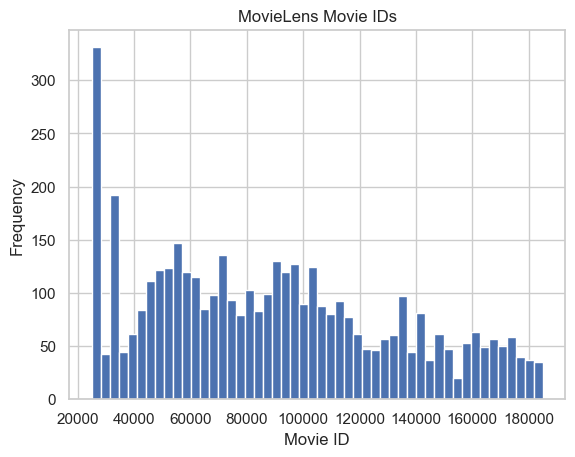

In [1096]:
#Frequency for movieId We need to modify this as to make the longest bar more valid with the other bar
plt.hist(movies['movieId'], bins=50, range=(25000, 185000))
plt.title('MovieLens Movie IDs')
plt.xlabel('Movie ID')
plt.ylabel('Frequency')
plt.show()

In [1097]:
# Create a list of all the genres
genres_list = movies['genres'].str.split('|')
genres = genres_list.explode()

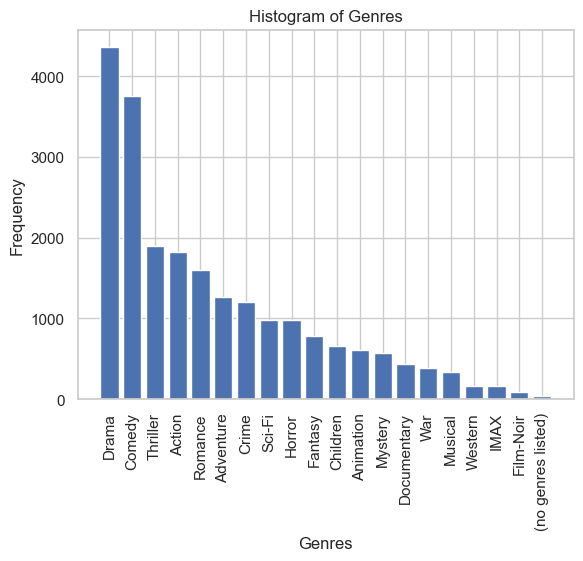

In [1098]:
#Genres
genres_counts = genres.value_counts()
plt.bar(genres_counts.index, genres_counts.values)
plt.xlabel('Genres')
plt.ylabel('Frequency')
plt.title('Histogram of Genres')
plt.xticks(rotation=90)
plt.show()

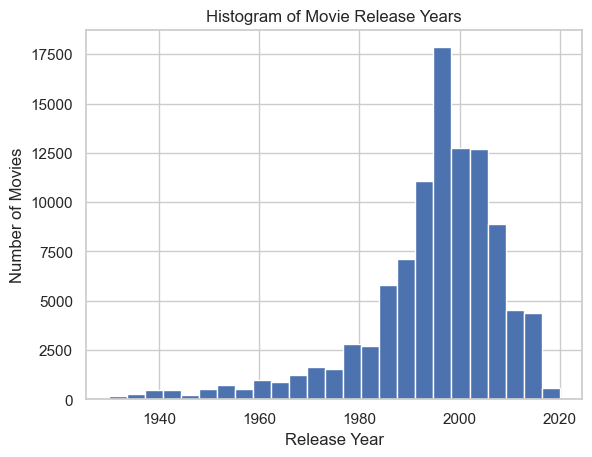

In [1099]:
# Plot the histogram
plt.hist(data['release year'].dropna(), bins=25, range=(1930, 2020))
plt.xlabel('Release Year')
plt.ylabel('Number of Movies')
plt.title('Histogram of Movie Release Years')
plt.show()

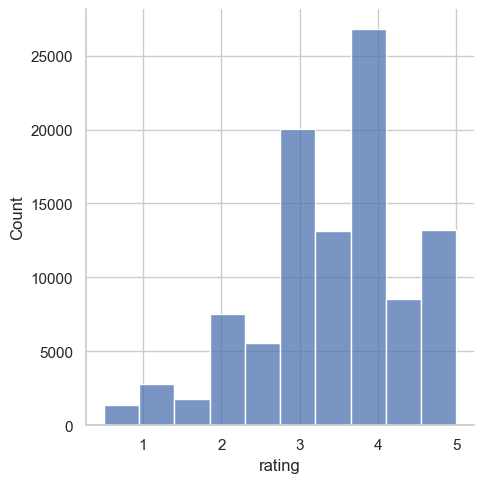

In [1100]:
#Count of Ratings
sns.set_theme(style="whitegrid")
sns.displot(ratings, x="rating", bins=10, color="b")

In [1101]:
#Grouping the ratings by movie ID
groupby_ratings = ratings.groupby('movieId')['rating']
#Calculating the mean rating for each movie
average_rating = groupby_ratings.mean()
average_rating.head()

movieId
1    3.920930
2    3.431818
3    3.259615
4    2.357143
5    3.071429
Name: rating, dtype: float64

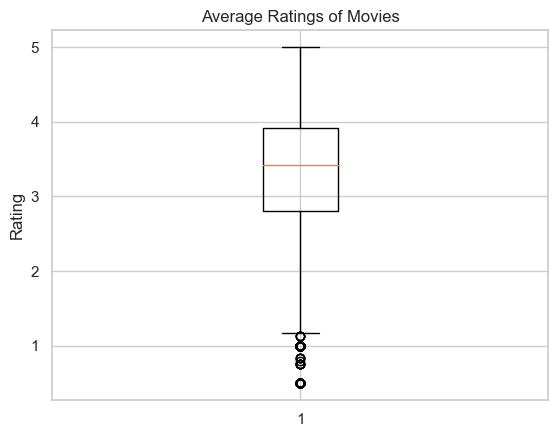

In [1102]:
# Boxplot of the Average rating
plt.boxplot(average_rating)
plt.title('Average Ratings of Movies')
plt.ylabel('Rating')
plt.show()

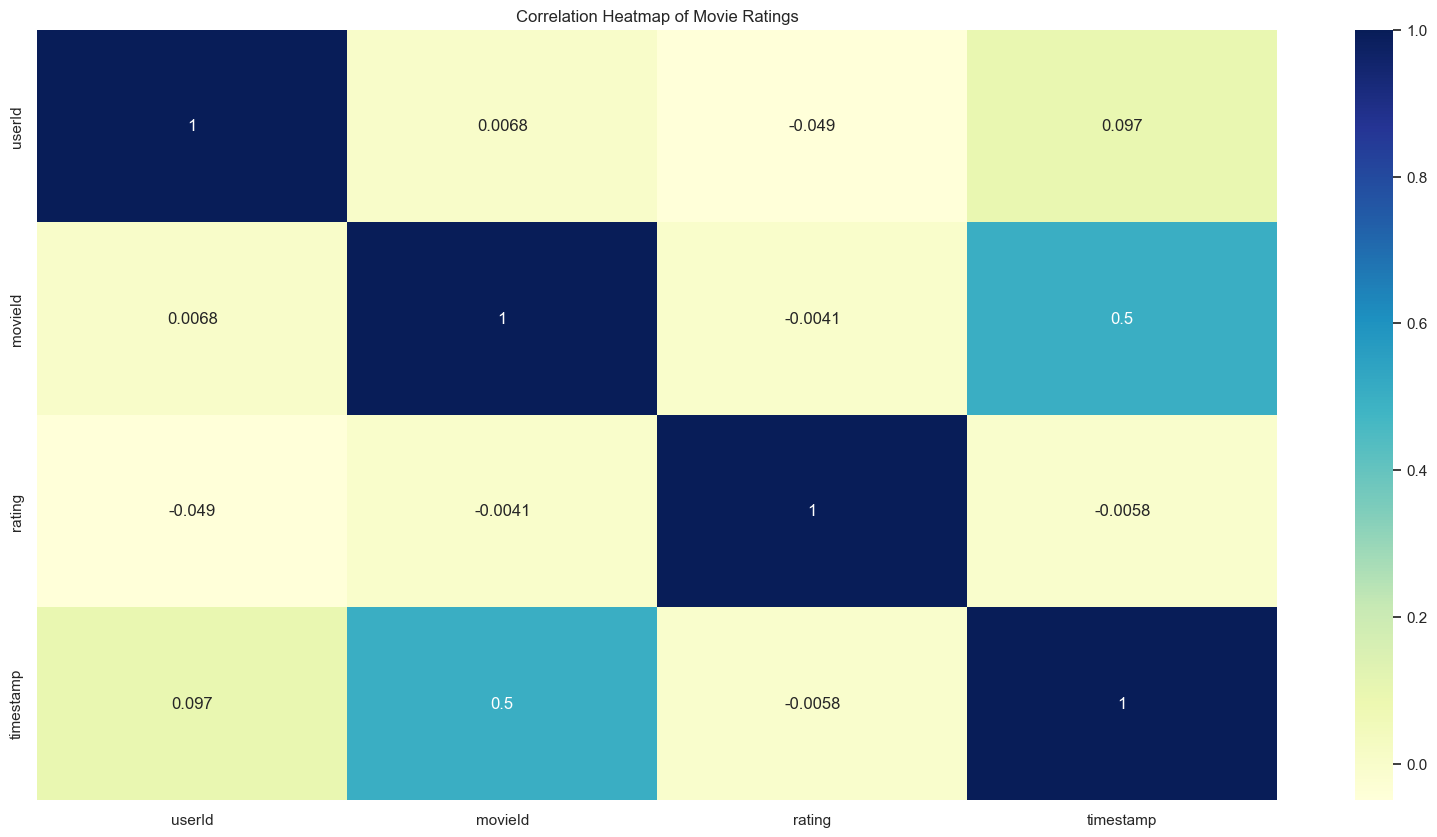

In [1103]:
ratings_df = ratings['rating'].astype(int)
ratings['rating'] = ratings['rating']
corr = ratings.corr()

plt.figure(figsize=(20,10))
sns.heatmap(corr, cmap='YlGnBu', annot=True)
plt.title('Correlation Heatmap of Movie Ratings')
plt.show()

From the above we see that there is no real correlation with rating. THe only one is timestamp with movieID, only because reviews are mostly written after the movie is released, Thus as the movieId increases the timestamp increases.

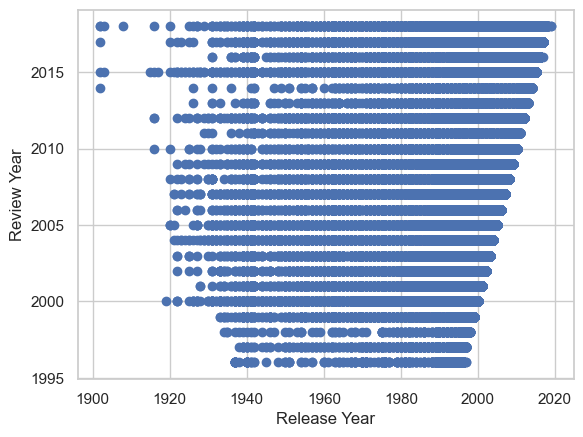

In [1104]:
#Not sure about this need to ask sir
plt.scatter(df_release_review['release year'], df_release_review['year'])

# Set the labels for the axes
plt.xlabel('Release Year')
plt.ylabel('Review Year')

# Show the plot
plt.show()

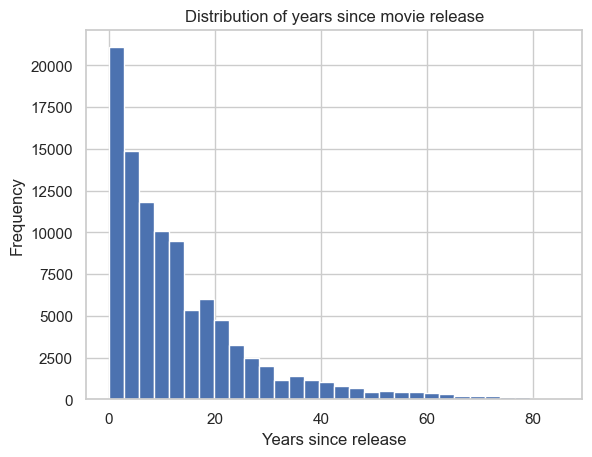

In [1105]:
#Even this
# Plot the number of years since release
df_release_review['years_since_release'].plot.hist(bins=30, range = (0,85))
# Add labels and title to the plot
plt.xlabel('Years since release')
plt.ylabel('Frequency')
plt.title('Distribution of years since movie release')
plt.show()

In [1106]:
#PCA for exploratory analysis
# Create a pivot table to transform the dataframe into a matrix
data_pivot = data.pivot_table(index=['userId'], columns=['title'], values='rating')

# Fills missing values with zeros
data_pivot = data_pivot.fillna(0)

# Apply PCA to reduce the dimensionality of the matrix
pca = PCA(n_components=2)
fit_transform = pca.fit_transform(data_pivot)
fit_transform

array([[ 14.78135561,  13.85028283],
       [-10.68708677,  -5.22705167],
       [-12.6947984 ,  -0.46295596],
       ...,
       [ 49.18710957,   4.8183602 ],
       [-11.20401142,   1.52393497],
       [ 65.63678653, -42.226513  ]])

Text(0, 0.5, 'Principal Component 2')

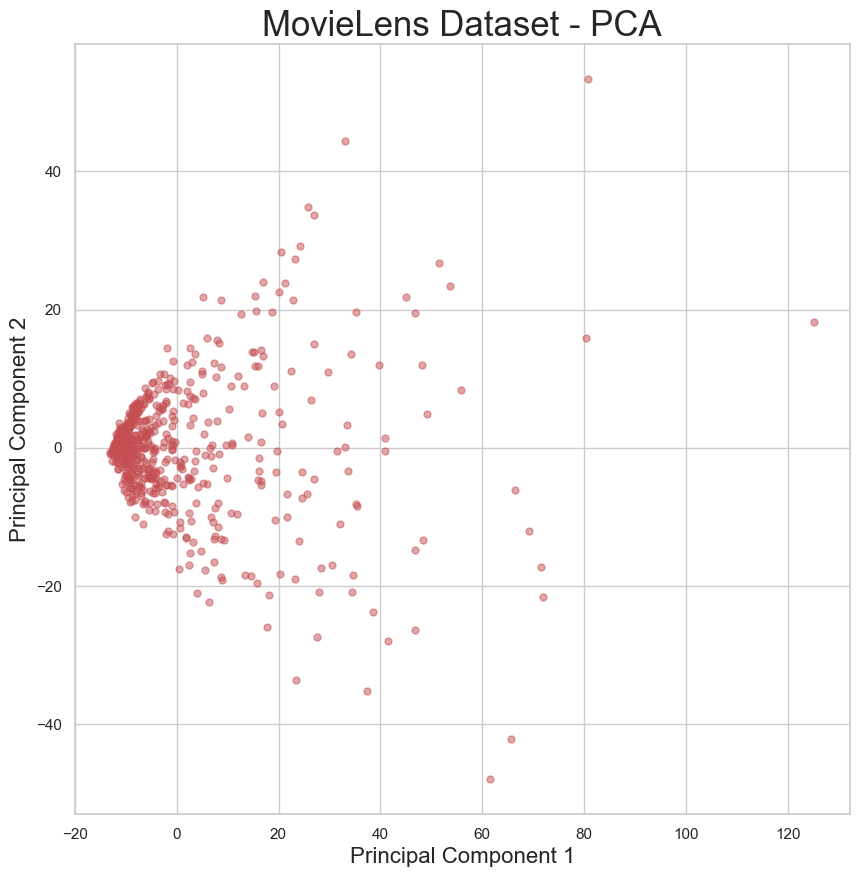

In [1107]:
plt.figure(figsize=(10,10))
plt.scatter(fit_transform[:,0], fit_transform[:,1], s=25, alpha=0.5, c='r')
plt.title('MovieLens Dataset - PCA', fontsize=25)
plt.xlabel('Principal Component 1', fontsize=16)
plt.ylabel('Principal Component 2', fontsize=16)

# Data Cleaning

In [1108]:
# TODO: remove any nulls
# TODO: Identify any problematic values (Title of movies, some movies have same name and release year, you need to research this situation and address accordingly)
# Arranged the duplicates in the above section as I merged the tables

In [1109]:
#remove any nulls
data.dropna(inplace=True)
data.head()

,movieId,title,genres,release year,userId,rating,timestamp
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,1,4.0,964982703
1,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,5,4.0,847434962
2,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,7,4.5,1106635946
3,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,15,2.5,1510577970
4,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,17,4.5,1305696483


In [1110]:
# Create a new dataframe with one hot encoded genres
genres_df = updated_movies['genres'].str.get_dummies('|')

#Joining the new dataframe with original movies
movies_with_genres = updated_movies.join(genres_df)
# Drop the original genres column
movies_with_genres.drop('genres', axis=1, inplace=True)


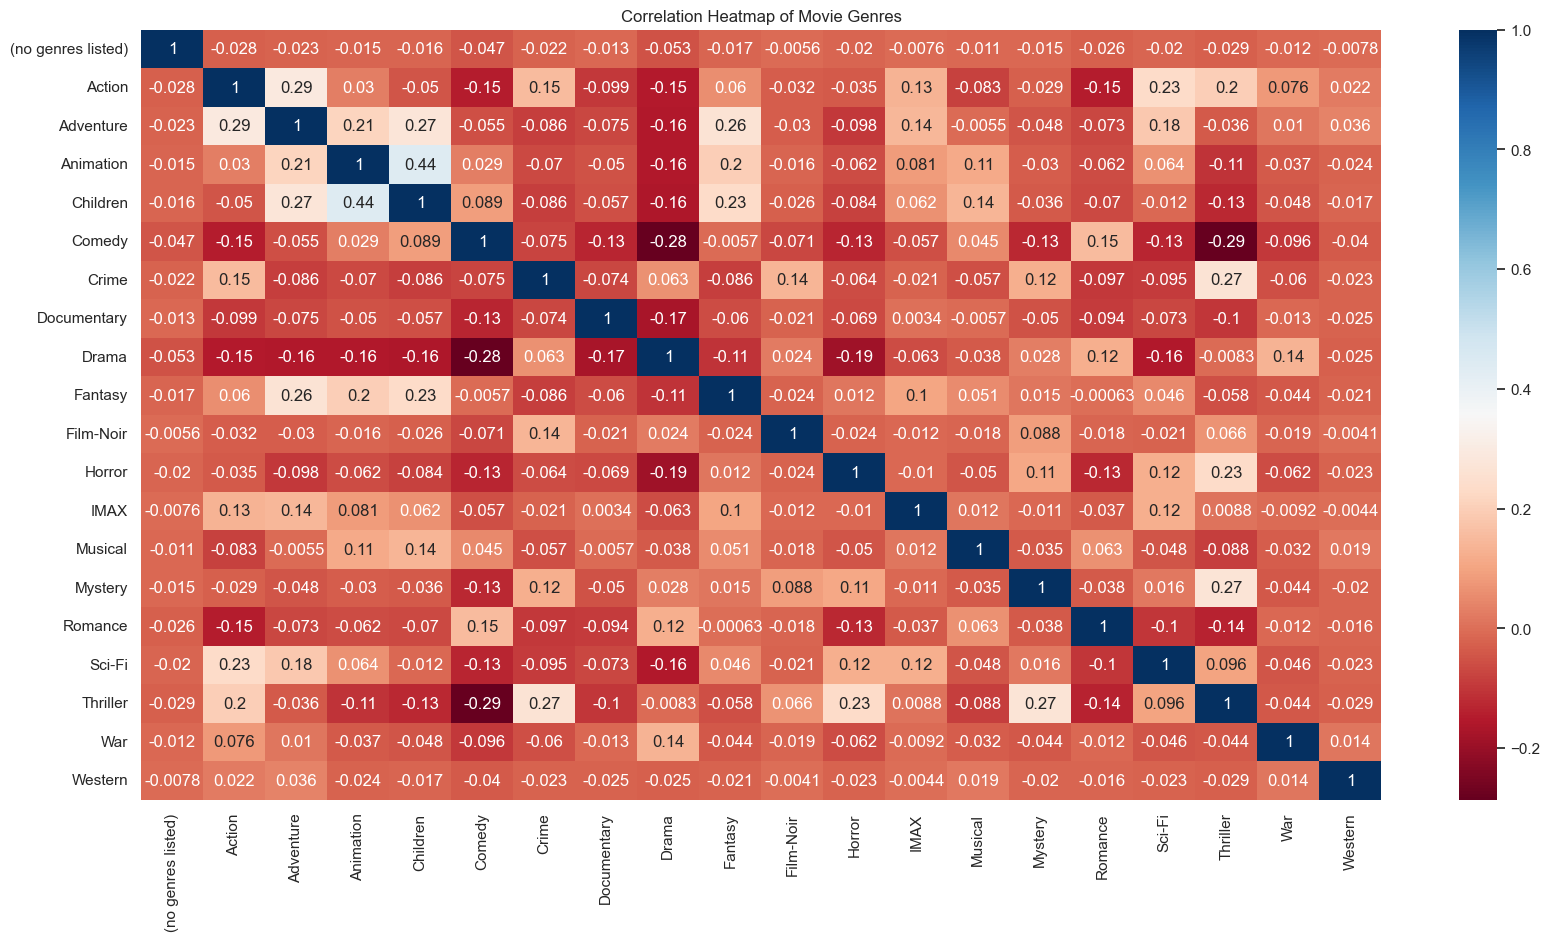

In [1111]:
#Correlation of genres
corr = genres_df.corr()

plt.figure(figsize=(20,10))
sns.heatmap(corr, cmap='RdBu', annot=True)
plt.title('Correlation Heatmap of Movie Genres')
plt.show()

# Data Transformation

In [1112]:
# TODO: At a later stage, not first iteration of this attempt, you might want to consider researching what PCA is.
# TODO: Consider manipulating some variables, such as the review date and calculate the number of years from the movie release year to the review date

# Data Splitting

In [1113]:
# TODO: Split the data in different ratios (70:30, 80:20, 90:10) then run the experiments. This will allow you to answer a research question: What impact does the train to test split ratio have on the model.
# TODO: At a later point in time (even third year) you might want to consider different cross validation techniques (https://neptune.ai/blog/cross-validation-in-machine-learning-how-to-do-it-right)
train_ratings, test_ratings = train_test_split(data, test_size=0.1, random_state=42)
train1, test1 = train_test_split(data, test_size=0.2, random_state=42)
#train_ratings, test_ratings = train_test_split(ratings, test_size=0.2, random_state=42)

# Model training

In [1114]:
# TODO: create a model that recommends a movie given certain parameters. The most naive would be the general movie average rating, then you can add other factors, such as genre, release year, etc etc.
# TODO: at a later point in time, introduce a different algorithm.
# TODO: at an even later point in time, consider an advanced technique. https://medium.com/stanford-cs224w/graph-neural-network-based-movie-recommender-system-5876b9686df3

In [1115]:
#Make use of the collaborative filtering tutorial to use for another algorithm SVD

In [1116]:
#Given the most naive recommendation system would be the general movie rating
#Calculating the mean rating of every movie.
#Sorting the movies in descending order in which the best rating would come first
groupby_rating_movies = test1.groupby('title')['rating']
average_rating_movies = groupby_rating_movies.mean()
sort_rating = average_rating_movies.sort_values(ascending=False)
top_movies = sort_rating.index.tolist()

# Recommend the top-rated movies to the user
print("Top 10 recommended Movies:")
for title in sort_rating.head(10).index:
 for rating in sort_rating.head(1):
  print(f"{title}: {rating}")

# Predict ratings for the testing set
test1['predicted_rating'] = test1['movieId'].apply(lambda x: 5 if x in top_movies[:10] else 3)

Top 10 recommended Movies:
Hunting Elephants: 5.0
On the Trail of the Bremen Town Musicians: 5.0
All That Jazz: 5.0
Odd Life of Timothy Green, The: 5.0
Rain: 5.0
Swept Away (Travolti da un insolito destino nell'azzurro mare d'Agosto): 5.0
Radio Day: 5.0
Quiet Man, The: 5.0
Meatballs: 5.0
Blue Planet II: 5.0


In [1117]:
#Add another filter release year
userid = 217
# Watched movies by the user
watched_movies = train_ratings[train_ratings['userId'] == userid]['movieId']

In [1118]:
watched_movies

44986    2567
54243    3430
32123    1488
36505    1917
18166     733
         ... 
37892    2002
26790    1222
21689    1007
53222    3274
25939    1210
Name: movieId, Length: 557, dtype: int64

In [1119]:
# Movies that has not been watched by the user
test_new_movies = test_ratings[test_ratings['userId'] == userid]
unwatched_movies = test_new_movies['movieId'].isin(watched_movies).apply(lambda x: not x)
test_new_movies = test_new_movies[unwatched_movies]

In [1120]:
# Genres of movies user has watched
genre_data = movies[movies['movieId'].isin(watched_movies)]['genres'].str.get_dummies(sep='|')

In [1121]:
# Calculate the average rating for each release year
avg_ratings_release_year = train_ratings.groupby('release year')['rating'].mean()

In [1122]:
# Sort the release years by the number of watched movies
avg_ratings_release_year = pd.merge(avg_ratings_release_year, train_ratings.loc[train_ratings['userId'] == userid,
                                         'release year'].value_counts().rename_axis('release year').reset_index(name='count'),
                                           on='release year')
sort_ratings = avg_ratings_release_year.sort_values(['count','rating'], ascending=False)
top_release_year = sort_ratings.head(5)['release year'].tolist()
top_release_year

[1997, 1996, 1998, 1994, 1995]

In [1123]:
watched_movies.head(10)

44986    2567
54243    3430
32123    1488
36505    1917
18166     733
21885    1022
30939    1380
43236    2402
33674    1617
43749    2427
Name: movieId, dtype: int64

In [1124]:
user_item_matrix = pd.pivot_table(train_ratings, index='userId', columns='movieId', values='rating')

In [1125]:
movie_similarity = cosine_similarity(genre_data)

In [1126]:
def in_top_years(movieid):
    movie_year = train_ratings.loc[train_ratings['movieId'] == movieid, 'release year'].iloc[0]
    return movie_year in top_release_year

In [1127]:
# watched_movies = train_ratings.loc[train_ratings['userId'] == userid][['movieId','release year']]
# watched_movies

In [1128]:
# Creating a list of similar movies that the user has watched
similar_movies = []
for movieid in watched_movies:
    if movieid-1 >= len(movie_similarity):
        continue
    similarities = [(row[1]['movieId'], movie_similarity[movieid-1][row[1]['movieId']-1])
                 for row in movies.iterrows()
                   if row[1]['movieId'] != movieid and row[1]['movieId']-1<len(movie_similarity)]
    similarities.sort(reverse=True, key=lambda x: x[1])
    similar_movies.extend([x[0] for x in similarities[:5]])

In [1129]:
# Number of times the movie appears
movie_recommendations = pd.Series(similar_movies).value_counts().sort_values(ascending=False)
top_recommendations = list(movie_recommendations[:10].index)
top_recommendations

[16, 39, 32, 40, 19, 22, 117, 72, 6, 11]

In [1130]:
# Get the genres of the top recommendations
top_genres = []
for top in top_recommendations:
    genres = movies.loc[movies['movieId']==top]['genres'].values[0].split('|')
    top_genres.extend(genres)

In [1131]:
# Number of times the genre appears
genre_recommendations = pd.Series(top_genres).value_counts().sort_values(ascending=False)
genre_recommendations

Drama       6
Crime       4
Comedy      4
Thriller    3
Romance     2
Mystery     2
Sci-Fi      1
Horror      1
Action      1
dtype: int64

In [1132]:
def predict_rating(userid, movieid):
    if movieid not in user_item_matrix.columns:
        return 0
    # Made use of the weighted rating to calculate the predicted ratings of the user that he gives to the movie
    similarity_scores = cosine_similarity(user_item_matrix.fillna(0), user_item_matrix.loc[userid].fillna(0).values.reshape(1, -1))
    weighted_ratings = similarity_scores.squeeze().dot(user_item_matrix[movieid].fillna(0))
    weighted_similarity = similarity_scores.squeeze().dot(user_item_matrix[movieid].notna())
    predicted_rating = weighted_ratings / weighted_similarity
    return predicted_rating


In [1133]:
# Compute predicted ratings for similar movies
predicted_ratings = []
for movieid in top_recommendations:
    predicted_rating = predict_rating(userid, movieid)
    predicted_ratings.append((movieid, predicted_rating))

In [1134]:
predicted_ratings

[(16, 3.862578663516072),
 (39, 3.201270515820949),
 (32, 3.996649301325424),
 (40, 4.710430472082985),
 (19, 2.827670576347758),
 (22, 3.189681337786349),
 (117, 3.0),
 (72, 2.9834431813806352),
 (6, 3.8049400506907394),
 (11, 3.6553592823638765)]

In [1135]:
# Recommend top-rated movies based on predicted ratings
recommended_movies = pd.DataFrame(predicted_ratings, columns=['movieId', 'predicted_rating'])
recommended_movies = recommended_movies.merge(movies[['movieId', 'title', 'genres']], on='movieId', how='left')
recommended_movies = recommended_movies.merge(data[['movieId','release year']], on='movieId', how='left')
recommended_movies = recommended_movies.drop_duplicates()

In [1136]:
recommended_movies = recommended_movies.sort_values(by='predicted_rating', ascending=False)
recommended_movies.head(10)

,movieId,predicted_rating,title,genres,release year
363,40,4.710430,"Cry, the Beloved Country (1995)",Drama,1995
186,32,3.996649,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller,1995
0,16,3.862579,Casino (1995),Crime|Drama,1995
497,6,3.804940,Heat (1995),Action|Crime|Thriller,1995
599,11,3.655359,"American President, The (1995)",Comedy|Drama|Romance,1995
82,39,3.201271,Clueless (1995),Comedy|Romance,1995
453,22,3.189681,Copycat (1995),Crime|Drama|Horror|Mystery|Thriller,1995
489,117,3.000000,"Young Poisoner's Handbook, The (1995)",Crime|Drama,1995
490,72,2.983443,Kicking and Screaming (1995),Comedy|Drama,1995
365,19,2.827671,Ace Ventura: When Nature Calls (1995),Comedy,1995


In [1137]:
test_new_movies = test_new_movies[test_new_movies['userId'] == userid]  # ratings for the user in the test set
predicted_ratings_new_movies = []
for movieid in test_new_movies['movieId']:
    print(movieid) # Add this line to check movieId value
    predicted_rating = predict_rating(userid=userid, movieid=movieid)

    predicted_ratings_new_movies.append(predicted_rating)

661
2748
3269
558
1882
2991
548
2371
367
1061
2431
3489
3039
485
1602
3543
2393
2496
3070
1729
3082
3448
1198
2408
2265
2150
3527
2533
1556
50
317
3392
2535
3132
2040
2985
1689
479
1911
2011
2822
2532
3175
1711
1527
1954
472
1671
3422
504
3387
2796
19
1599
1518
2530


In [1138]:
predicted_ratings

[(16, 3.862578663516072),
 (39, 3.201270515820949),
 (32, 3.996649301325424),
 (40, 4.710430472082985),
 (19, 2.827670576347758),
 (22, 3.189681337786349),
 (117, 3.0),
 (72, 2.9834431813806352),
 (6, 3.8049400506907394),
 (11, 3.6553592823638765)]

In [1139]:
test_new_movies

,movieId,title,genres,release year,userId,rating,timestamp
17654,661,James and the Giant Peach,Adventure|Animation|Children|Fantasy|Musical,1996,217,3.0,955942698
47610,2748,Allan Quatermain and the Lost City of Gold,Action|Adventure|Comedy,1987,217,2.0,955941623
53135,3269,Forever Young,Drama|Romance|Sci-Fi,1992,217,2.0,955942294
15122,558,"Pagemaster, The",Action|Adventure|Animation|Children|Fantasy,1994,217,3.0,955941666
36129,1882,Godzilla,Action|Sci-Fi|Thriller,1998,217,2.0,955941587
50412,2991,Live and Let Die,Action|Adventure|Thriller,1973,217,3.0,956194846
14820,548,Terminal Velocity,Action|Mystery|Thriller,1994,217,3.0,955941233
42746,2371,Fletch,Comedy|Crime|Mystery,1985,217,2.0,955943760
10757,367,"Mask, The",Action|Comedy|Crime|Fantasy,1994,217,3.0,955942978
22663,1061,Sleepers,Thriller,1996,217,3.0,955942953


In [1140]:
predicted_ratings_new_movies

[3.5376423169881366,
 1.7713622096325397,
 2.8206712536177894,
 3.015721646389916,
 2.083512641455439,
 3.555871511922544,
 2.5215782121955552,
 3.1005855963030466,
 3.1778989492258485,
 3.5441395743906803,
 3.3186227072797023,
 3.312487884335408,
 3.6238421356400243,
 2.845506477233913,
 1.7601073323168304,
 3.5832853659937682,
 3.2511592012591763,
 3.1090681013367227,
 3.7136716305417643,
 3.5954608730694617,
 3.1781926054321183,
 3.853698355538442,
 4.326699929942076,
 1.638464616015557,
 2.5,
 3.786562938518428,
 3.6008633223563176,
 3.087464446842299,
 1.424354502370271,
 4.240375162765362,
 3.231053999926461,
 2.6221375850061226,
 2.5353961499772306,
 0,
 2.8318427080100945,
 3.2818860072474263,
 2.1899679630175197,
 2.0,
 2.4071455156759187,
 3.383599794036299,
 3.076033555954937,
 2.8047877028072,
 3.6222113322036953,
 2.9962648061693034,
 3.800543808847744,
 3.915638694955031,
 2.5589826899792634,
 0,
 3.563912245699308,
 3.0,
 2.8088631833078312,
 2.7516371912320756,
 2.82767

# Model evaluation

In [1141]:
# TODO: evaluate each model and generate metric results. Answer the research question: which model performs better in a specific situation?

In [1142]:
#The naive average rating
rmse = math.sqrt(mean_squared_error(test1['rating'], test1['predicted_rating']))
mae = mean_absolute_error(test1['rating'], test1['predicted_rating'])
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

RMSE: 1.1635570607910808
MAE: 0.9466233637445458


In [1143]:
#Hybird filtering using the user preferences and the genres
rmse_user = math.sqrt(mean_squared_error(test_new_movies['rating'], predicted_ratings_new_movies))
mae_user = mean_absolute_error(test_new_movies['rating'], predicted_ratings_new_movies)
print(f"RMSE: {rmse_user:.5f}")
print(f"MAE: {mae_user:.5f}")

RMSE: 0.98810
MAE: 0.79965


# Post-Processing

This is an advanced step and does not necessarily need to be done in 2nd year, yet it is good that you know that it exists. You can, but are not obliged to do so, consider for 3rd year.

In [1144]:
# TODO: Assess the incorrect recommendations and investigate to answer the research question: Which recommendations were bad and why did they occur?